## Forecasting usando RNN
El objetivo de este pequeño proyecto es realizar un forecast, corrigiendo los realizados por Prophet de Meta en un proyecto anterior. Muchas veces, Prophet es poco flexible con los datos, sobre todo cuando estos no presentan una tendencia y son escasos; lo mismo ocurre con casi todos los modelos, incluyendo las RNN, que requieren más datos.
Se hace una omisión, ya que modelos para pocos datos, como Promedio Móvil o Exponential Smoothing, otorgan valores muy similares entre sí, dejando los resultados casi constantes; las redes neuronales presentan un poco más de precisión en este sentido.
A continuación realizaremos diferentes predicciones a distintas categorías.

### 1.1 Cargamos las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import os
from dotenv import load_dotenv

/Users/erickavendanogarcia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
### 1.0 Fijar semilla para reproducibilidad
import tensorflow as tf
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Configurar tensorflow para reproducibilidad estricta (opcional)
# Esto puede hacer que el entrenamiento sea un poco más lento
tf.config.experimental.enable_op_determinism()


### 1.2 Cargamos los datos necesarios

In [3]:
load_dotenv(dotenv_path=".env", override=True)
df_prueba = pd.read_csv(os.getenv("csv_ruta"))
df_prueba

Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 7


,ds,y
0,2024-01-01,3467585
1,2024-02-01,765733
2,2024-03-01,3260182
3,2024-04-01,489422
4,2024-05-01,280569
5,2024-06-01,120035
6,2024-07-01,117860
7,2024-08-01,87600
8,2024-09-01,82089
9,2024-10-01,15373807


### 1.3 Normalizamos los datos

In [4]:
# Normalizar la columna "y"
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(df_prueba[["y"]])

### 1.4 Creación, entrenamiento y predicción del modelo

In [5]:

# Crear secuencias para RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 4
X, y = create_sequences(y_scaled, seq_length)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

# Construir modelo RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(30, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(30,activation="relu"),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/Users/erickavendanogarcia/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 30)       │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,821 (11.02 KB)

 Trainable params: 2,821 (11.02 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Entrenar modelo

history = model.fit(X_train, y_train, epochs=10, batch_size=14, validation_data=(X_test, y_test))

# Predecir los siguientes 6 pasos
# ---------------------------
last_sequence = X_test[-1:]  # última secuencia del conjunto de prueba
preds = []

for _ in range(6):
    pred = model.predict(last_sequence, verbose=0)
    preds.append(pred[0,0])
    # Convertir pred a 3D y concatenar a la secuencia para siguiente predicción
    pred_3d = pred.reshape((1,1,1))
    last_sequence = np.concatenate([last_sequence[:,1:,:], pred_3d], axis=1)

# Desnormalizar predicciones
preds_rescaled = scaler.inverse_transform(np.array(preds).reshape(-1,1))

Epoch 1/10


2025-08-17 17:12:18.251137: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-17 17:12:18.252069: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1339 - val_loss: 0.3088
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1219 - val_loss: 0.2743
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1101 - val_loss: 0.2416
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0996 - val_loss: 0.2114
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0908 - val_loss: 0.1825
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0837 - val_loss: 0.1562
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0780 - val_loss: 0.1352
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0739 - val_loss: 0.1185
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0712 - val_loss: 0.1065
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0697 - val_loss: 0.0987


In [7]:
preds_rescaled

array([[12274620. ],
       [14626872. ],
       [ 6196130.5],
       [ 9967864. ],
       [ 9055163. ],
       [ 4157937. ]], dtype=float32)

### 1.5 Grafica de resultados

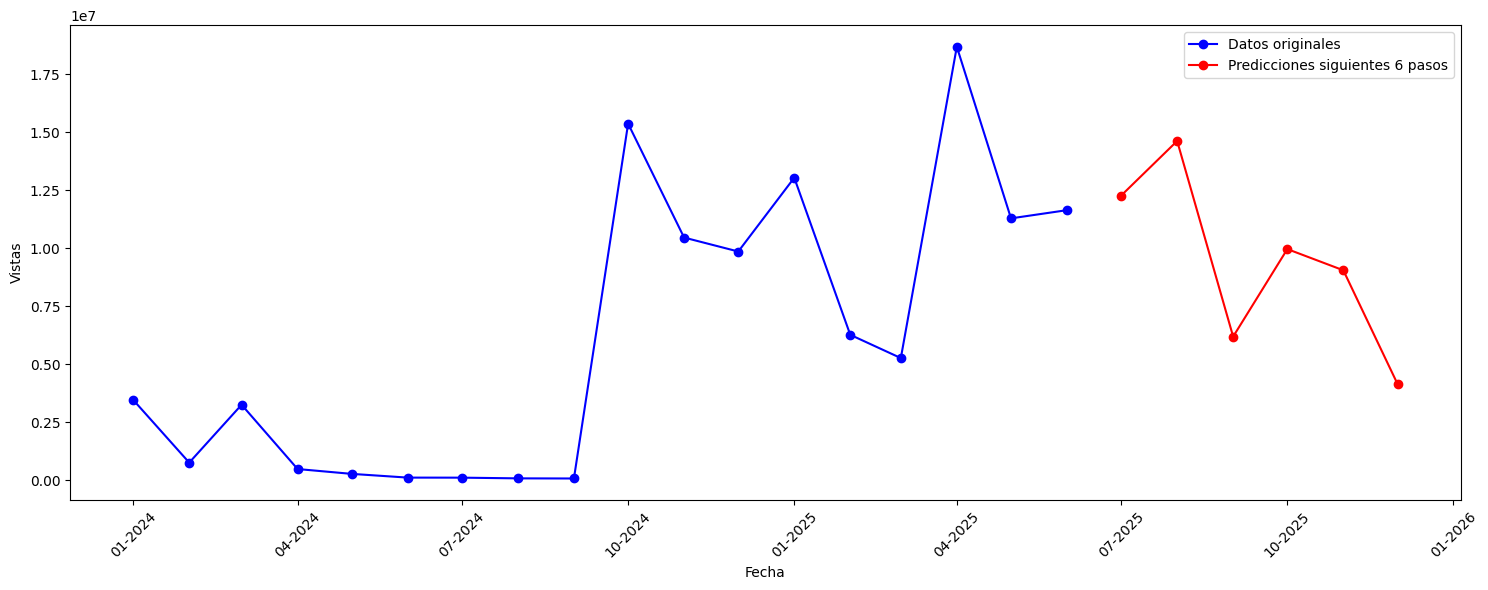

In [8]:
import matplotlib.dates as mdates

# Asegurar que 'ds' sea datetime
df_prueba["ds"] = pd.to_datetime(df_prueba["ds"])

# Última fecha disponible
last_date = df_prueba["ds"].iloc[-1]

# Crear fechas futuras (6 meses después de la última fecha)
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=6, freq="MS")

# Gráfica
plt.figure(figsize=(15,6))
plt.plot(df_prueba["ds"], df_prueba["y"], 'bo-', label="Datos originales")
plt.plot(future_dates, preds_rescaled, 'ro-', label="Predicciones siguientes 6 pasos")

plt.xlabel("Fecha")
plt.ylabel("Vistas")
plt.legend()

# Rotar fechas en eje X
plt.xticks(rotation=45)

# Formato mes-año
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
plt.tight_layout()
plt.show()


### 1.6 Validación del Modelo

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

y_true = y_test  # reales
y_pred = model.predict(X_test).flatten()  # predicciones

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape*100:.2f}%")

2025-08-17 17:12:23.553415: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-08-17 17:12:23.554216: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
MSE: 0.0987
MAE: 0.2279
MAPE: 37.43%


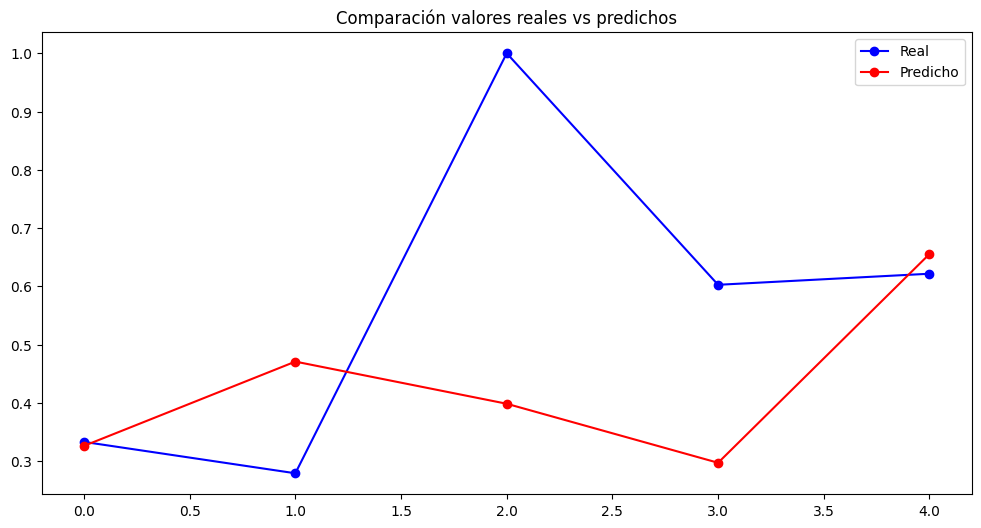

In [10]:
plt.figure(figsize=(12,6))
plt.plot(y_true,'bo-', label="Real")
plt.plot(y_pred,'ro-', label="Predicho")
plt.legend()
plt.title("Comparación valores reales vs predichos")
plt.show()


### 1.7 Generalización del modelo

17:12:25 - cmdstanpy - INFO - Chain [1] start processing
17:12:25 - cmdstanpy - INFO - Chain [1] done processing
2025-08-17 17:12:29.117966: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-17 17:12:29.118307: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDatas

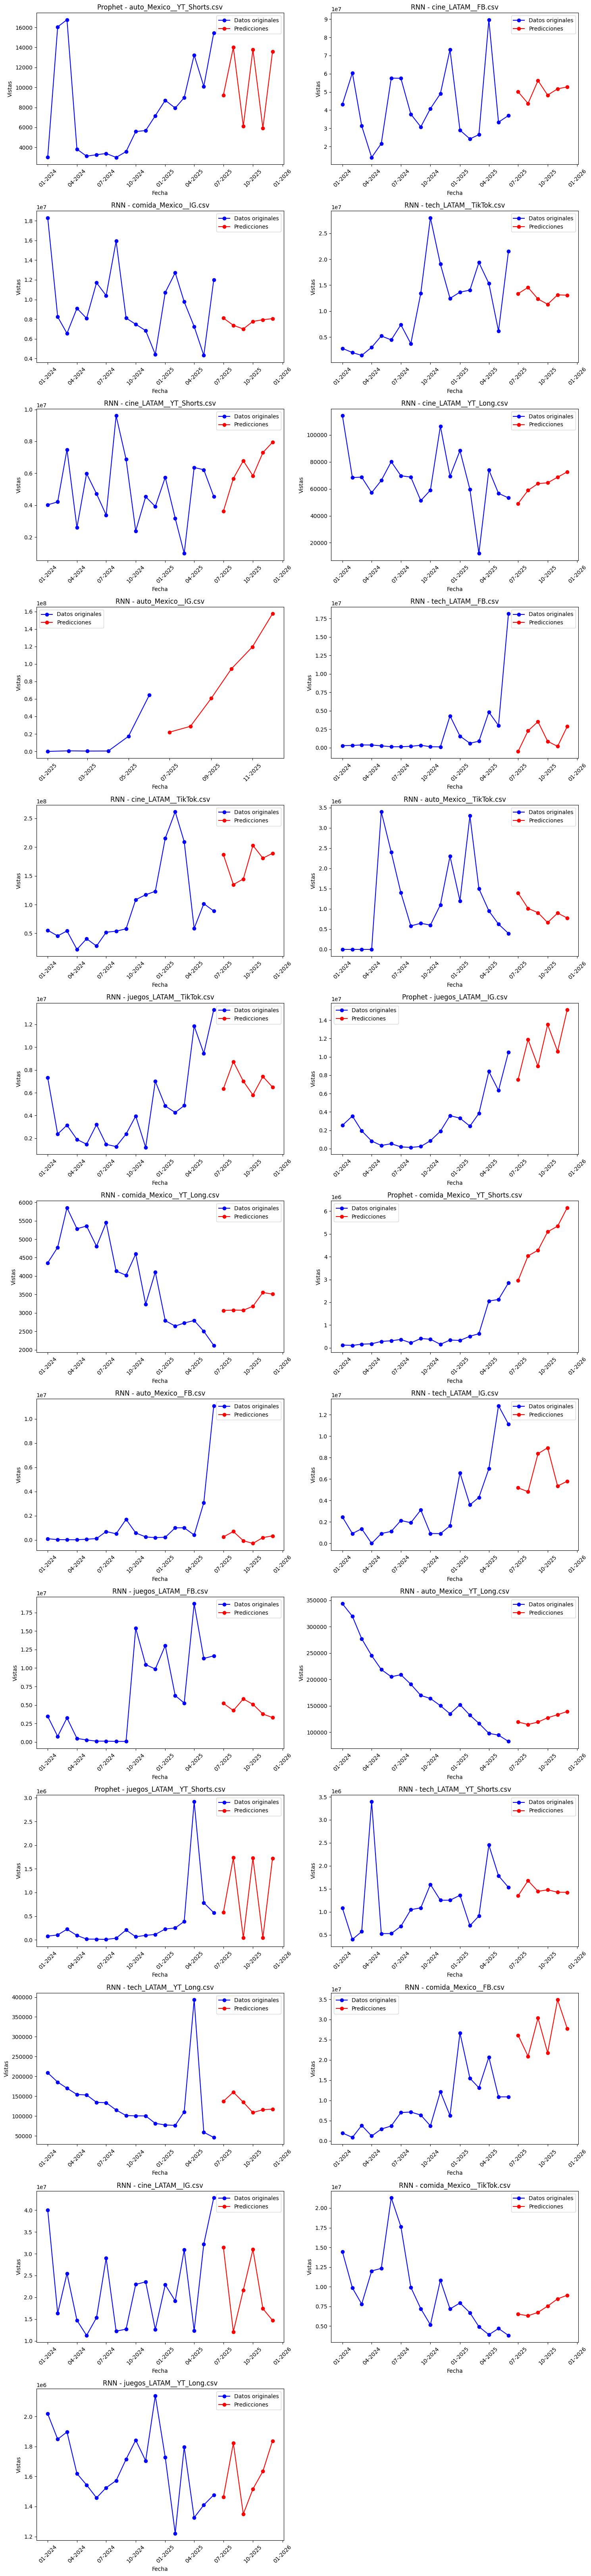

,file,model,ds,yhat
0,auto_Mexico__YT_Shorts.csv,Prophet,2025-07-01,9.230516e+03
1,auto_Mexico__YT_Shorts.csv,Prophet,2025-08-01,1.400177e+04
2,auto_Mexico__YT_Shorts.csv,Prophet,2025-09-01,6.129855e+03
3,auto_Mexico__YT_Shorts.csv,Prophet,2025-10-01,1.379500e+04
4,auto_Mexico__YT_Shorts.csv,Prophet,2025-11-01,5.923084e+03
...,...,...,...,...
145,juegos_LATAM__YT_Long.csv,RNN,2025-08-01,1.822547e+06
146,juegos_LATAM__YT_Long.csv,RNN,2025-09-01,1.350076e+06
147,juegos_LATAM__YT_Long.csv,RNN,2025-10-01,1.516990e+06
148,juegos_LATAM__YT_Long.csv,RNN,2025-11-01,1.634939e+06


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import matplotlib.dates as mdates
from prophet import Prophet

# ===================================================
# 1.0 Fijar semilla para reproducibilidad
# ===================================================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
tf.config.experimental.enable_op_determinism()

# ===================================================
# 1.1 Función auxiliar para crear secuencias
# ===================================================
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# ===================================================
# 1.2 Funciones de forecast
# ===================================================
def forecast_rnn(df, seq_length=4, future_steps=6, epochs=10, batch_size=14):
    scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler.fit_transform(df[["y"]])
    X, y = create_sequences(y_scaled, seq_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    model = keras.models.Sequential([
        keras.Input(shape=(None, 1)),
        keras.layers.SimpleRNN(30, return_sequences=True),
        keras.layers.SimpleRNN(30, activation="relu"),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    last_sequence = X_test[-1:]
    preds = []
    for _ in range(future_steps):
        pred = model.predict(last_sequence, verbose=0)
        preds.append(pred[0,0])
        last_sequence = np.concatenate([last_sequence[:,1:,:], pred.reshape((1,1,1))], axis=1)

    preds_rescaled = scaler.inverse_transform(np.array(preds).reshape(-1,1))
    future_dates = pd.date_range(df["ds"].iloc[-1] + pd.offsets.MonthBegin(1), periods=future_steps, freq="MS")
    return future_dates, preds_rescaled

def forecast_prophet(df, future_steps=6):
    model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.35)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=14)
    model.fit(df)
    future = model.make_future_dataframe(periods=future_steps, freq="MS")
    forecast = model.predict(future)
    forecast_future = forecast[forecast["ds"] > df["ds"].max()].copy()
    return forecast_future["ds"].values, forecast_future["yhat"].values

# ===================================================
# 1.3 Loop sobre todos los CSV y generar subplots
# ===================================================
data_folder = os.getenv("OUTPUT_DIR")
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))


prophet_files = [ "auto_Mexico__YT_Shorts.csv", "juegos_LATAM__IG.csv", "comida_Mexico__YT_Shorts.csv", "juegos_LATAM__YT_Shorts.csv", ]

n_files = len(csv_files)
n_cols = 2
n_rows = (n_files + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()
rnn_short_seq_files_str = os.getenv("RNN_SHORT_SEQ_FILES", "")
rnn_short_seq_files = [f.strip() for f in rnn_short_seq_files_str.split(",") if f]


# DataFrame para acumular resultados
all_predictions = []

for i, csv_path in enumerate(csv_files):
    df = pd.read_csv(csv_path)
    df["ds"] = pd.to_datetime(df["ds"])
    file_name = os.path.basename(csv_path)

    # --- Forecast ---
    if file_name in prophet_files:
        future_dates, preds = forecast_prophet(df)
        model_used = "Prophet"
    else:
        seq_len = 3 if file_name in rnn_short_seq_files else 4
        future_dates, preds = forecast_rnn(df, seq_length=seq_len)
        model_used = "RNN"

    # --- Guardar resultados en lista ---
    temp_df = pd.DataFrame({
        "file": file_name,
        "model": model_used,
        "ds": future_dates,
        "yhat": preds.flatten()
    })
    all_predictions.append(temp_df)

    # --- Plot ---
    ax = axes[i]
    ax.plot(df["ds"], df["y"], 'bo-', label="Datos originales")
    ax.plot(future_dates, preds, 'ro-', label="Predicciones")
    ax.set_title(f"{model_used} - {file_name}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Vistas")
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# Ocultar subplots vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Unir todo en un solo DataFrame
all_predictions_df = pd.concat(all_predictions, ignore_index=True)
all_predictions_df

In [12]:
all_predictions_df

,file,model,ds,yhat
0,auto_Mexico__YT_Shorts.csv,Prophet,2025-07-01,9.230516e+03
1,auto_Mexico__YT_Shorts.csv,Prophet,2025-08-01,1.400177e+04
2,auto_Mexico__YT_Shorts.csv,Prophet,2025-09-01,6.129855e+03
3,auto_Mexico__YT_Shorts.csv,Prophet,2025-10-01,1.379500e+04
4,auto_Mexico__YT_Shorts.csv,Prophet,2025-11-01,5.923084e+03
...,...,...,...,...
145,juegos_LATAM__YT_Long.csv,RNN,2025-08-01,1.822547e+06
146,juegos_LATAM__YT_Long.csv,RNN,2025-09-01,1.350076e+06
147,juegos_LATAM__YT_Long.csv,RNN,2025-10-01,1.516990e+06
148,juegos_LATAM__YT_Long.csv,RNN,2025-11-01,1.634939e+06


In [14]:
#Limpieza de datos
all_predictions_df = all_predictions_df.rename(columns={
    "file": "Sitio",
    "model": "Modelo",
    "ds": "Fecha",
    "yhat": "Predicciones"
})

# Separar el campo "Sitio" en vertical, region y red
df_split = all_predictions_df["Sitio"].str.replace(".csv", "", regex=False).str.split("__", expand=True)
df_split.columns = ["vertical_region", "red"]

# De vertical_region nos quedamos solo con la vertical (antes del "_")
df_split["vertical"] = df_split["vertical_region"].str.split("_").str[0]

# Agregar al DataFrame original
all_predictions_df["Vertical"] = df_split["vertical"]
all_predictions_df["Red_Social"] = df_split["red"]

# Reordenar columnas y eliminar la columna Sitio (ya no sirve)
all_predictions_df = all_predictions_df[["Vertical", "Red_Social", "Modelo", "Fecha", "Predicciones"]]

In [15]:
all_predictions_df

,Vertical,Red_Social,Modelo,Fecha,Predicciones
0,auto,YT_Shorts,Prophet,2025-07-01,9.230516e+03
1,auto,YT_Shorts,Prophet,2025-08-01,1.400177e+04
2,auto,YT_Shorts,Prophet,2025-09-01,6.129855e+03
3,auto,YT_Shorts,Prophet,2025-10-01,1.379500e+04
4,auto,YT_Shorts,Prophet,2025-11-01,5.923084e+03
...,...,...,...,...,...
145,juegos,YT_Long,RNN,2025-08-01,1.822547e+06
146,juegos,YT_Long,RNN,2025-09-01,1.350076e+06
147,juegos,YT_Long,RNN,2025-10-01,1.516990e+06
148,juegos,YT_Long,RNN,2025-11-01,1.634939e+06


In [16]:
all_predictions_df.to_csv("Forecating_Redes.csv", index=False)